In [1]:
# Importing libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px # For high-level plotting
import plotly.io as pio # For renderer settings
from plotly.subplots import make_subplots
import kaleido
# Statistical tools
from scipy.stats import skew, uniform, randint, loguniform

# Scikit-learn: preprocessing, model selection, evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

# Regression models
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Gradient boosting models
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import os
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv(r'C:\Users\Vstore Computer\Datasets\Walmart.csv', low_memory=False)

### Data Understanding
---

In [3]:
pd.set_option('display.max_columns', None)
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [4]:
df.columns

Index(['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature',
       'Fuel_Price', 'CPI', 'Unemployment'],
      dtype='object')

In [5]:
df.shape

(6435, 8)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         6435 non-null   int64  
 1   Date          6435 non-null   object 
 2   Weekly_Sales  6435 non-null   float64
 3   Holiday_Flag  6435 non-null   int64  
 4   Temperature   6435 non-null   float64
 5   Fuel_Price    6435 non-null   float64
 6   CPI           6435 non-null   float64
 7   Unemployment  6435 non-null   float64
dtypes: float64(5), int64(2), object(1)
memory usage: 402.3+ KB


In [7]:
df.duplicated().sum()

np.int64(0)

In [8]:
df.isna().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,6435.0,2.300000e+01,12.988182,1.000,12.000,23.000000,3.400000e+01,4.500000e+01
Weekly_Sales,6435.0,1.046965e+06,564366.622054,209986.250,553350.105,960746.040000,1.420159e+06,3.818686e+06
Holiday_Flag,6435.0,6.993007e-02,0.255049,0.000,0.000,0.000000,0.000000e+00,1.000000e+00
Temperature,6435.0,6.066378e+01,18.444933,-2.060,47.460,62.670000,7.494000e+01,1.001400e+02
Fuel_Price,6435.0,3.358607e+00,0.459020,2.472,2.933,3.445000,3.735000e+00,4.468000e+00
CPI,6435.0,1.715784e+02,39.356712,126.064,131.735,182.616521,2.127433e+02,2.272328e+02
Unemployment,6435.0,7.999151e+00,1.875885,3.879,6.891,7.874000,8.622000e+00,1.431300e+01


In [10]:
for col in df.columns:
  count_values = df[col].value_counts()
  print(f'Column called \033[91m{col}\033[0m has \033[94m{len(count_values)}\033[0m unique values')

Column called Store has 45 unique values
Column called Date has 143 unique values
Column called Weekly_Sales has 6435 unique values
Column called Holiday_Flag has 2 unique values
Column called Temperature has 3528 unique values
Column called Fuel_Price has 892 unique values
Column called CPI has 2145 unique values
Column called Unemployment has 349 unique values


### Data Preparation

#### Data Cleaning

In [11]:
df.isnull().sum()

Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64

In [12]:
df.duplicated().sum()

np.int64(0)

No missing value and/or duplicated value

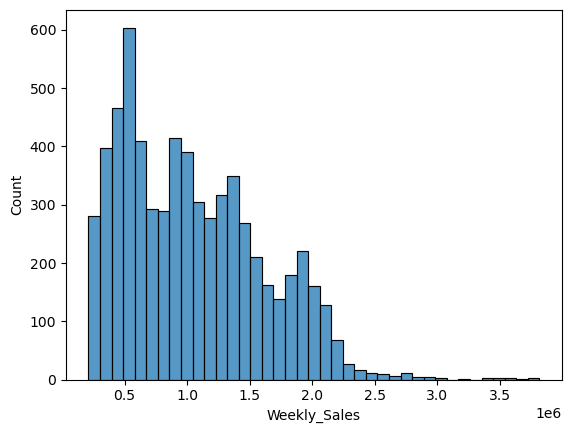

In [13]:
# Histogram
sns.histplot(df['Weekly_Sales']);

In [14]:
# IQR
q1 = df['Weekly_Sales'].quantile(0.25)
q3 = df['Weekly_Sales'].quantile(0.75)

iqr = q3-q1 #Interquartile range
fence_low  = q1-1.5*iqr
fence_high = q3+1.5*iqr

df.loc[(df['Weekly_Sales'] < fence_low) | (df['Weekly_Sales'] > fence_high)]

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
189,2,24-12-2010,3436007.68,0,49.97,2.886,211.064660,8.163
241,2,23-12-2011,3224369.80,0,46.66,3.112,218.999550,7.441
471,4,26-11-2010,2789469.45,1,48.08,2.752,126.669267,7.127
474,4,17-12-2010,2740057.14,0,46.57,2.884,126.879484,7.127
475,4,24-12-2010,3526713.39,0,43.21,2.887,126.983581,7.127
523,4,25-11-2011,3004702.33,1,47.96,3.225,129.836400,5.143
526,4,16-12-2011,2771397.17,0,36.44,3.149,129.898065,5.143
527,4,23-12-2011,3676388.98,0,35.92,3.103,129.984548,5.143
761,6,24-12-2010,2727575.18,0,55.07,2.886,212.916508,7.007
1329,10,26-11-2010,2939946.38,1,55.33,3.162,126.669267,9.003


In [15]:
# Handle outliers
# Using IQR
df_clean = df.loc[(df['Weekly_Sales'] >= fence_low) & (df['Weekly_Sales'] <= fence_high)]

df_clean

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106
...,...,...,...,...,...,...,...,...
6430,45,28-09-2012,713173.95,0,64.88,3.997,192.013558,8.684
6431,45,05-10-2012,733455.07,0,64.89,3.985,192.170412,8.667
6432,45,12-10-2012,734464.36,0,54.47,4.000,192.327265,8.667
6433,45,19-10-2012,718125.53,0,56.47,3.969,192.330854,8.667


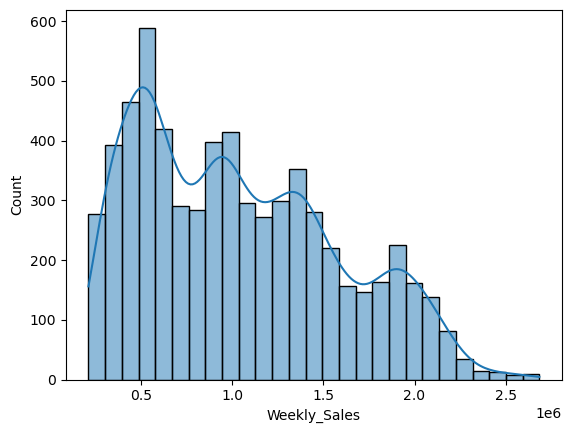

In [16]:
sns.histplot(df_clean['Weekly_Sales'], kde=True);

##### Convert Datatypes

In [17]:
# Change data types
df_clean['Holiday_Flag'] = df_clean['Holiday_Flag'].astype("category")

In [18]:
# Change data types
df_clean['Store'] = df_clean['Store'].astype("category")

In [19]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6401 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Store         6401 non-null   category
 1   Date          6401 non-null   object  
 2   Weekly_Sales  6401 non-null   float64 
 3   Holiday_Flag  6401 non-null   category
 4   Temperature   6401 non-null   float64 
 5   Fuel_Price    6401 non-null   float64 
 6   CPI           6401 non-null   float64 
 7   Unemployment  6401 non-null   float64 
dtypes: category(2), float64(5), object(1)
memory usage: 364.1+ KB


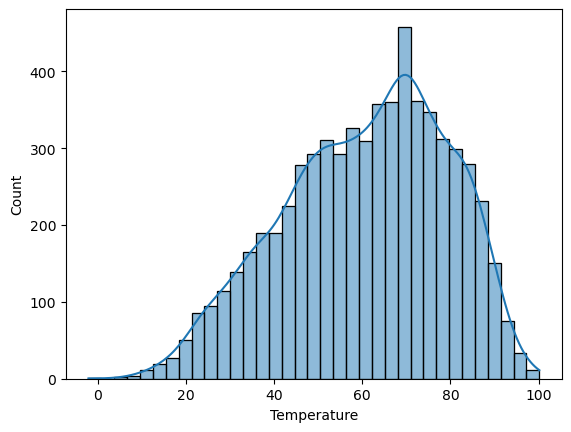

In [20]:
sns.histplot(df_clean['Temperature'], kde=True);

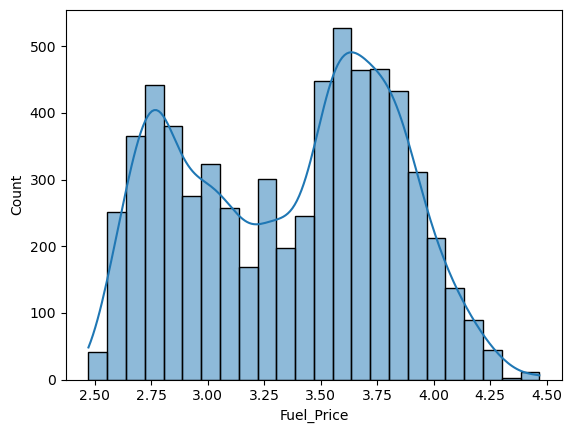

In [21]:
sns.histplot(df_clean['Fuel_Price'], kde=True);

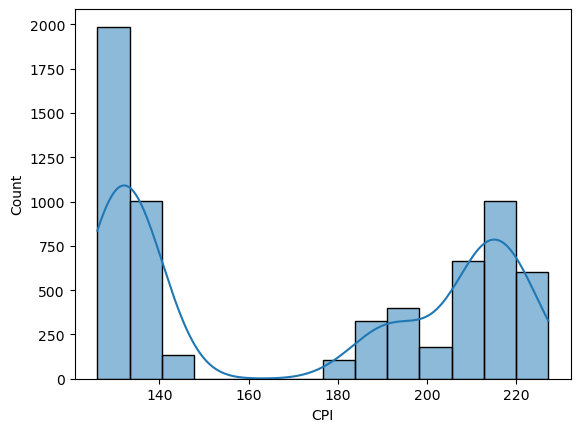

In [22]:
sns.histplot(df_clean['CPI'], kde=True);

Store
1     143
2     143
3     143
4     143
5     143
6     143
7     143
8     143
9     143
10    143
11    143
12    143
13    143
14    143
15    143
16    143
17    143
18    143
19    143
20    143
21    143
22    143
23    143
24    143
25    143
26    143
27    143
28    143
29    143
30    143
31    143
32    143
33    143
34    143
35    143
36    143
37    143
38    143
39    143
40    143
41    143
42    143
43    143
44    143
45    143
Name: count, dtype: int64

Holiday_Flag
0    5985
1     450
Name: count, dtype: int64



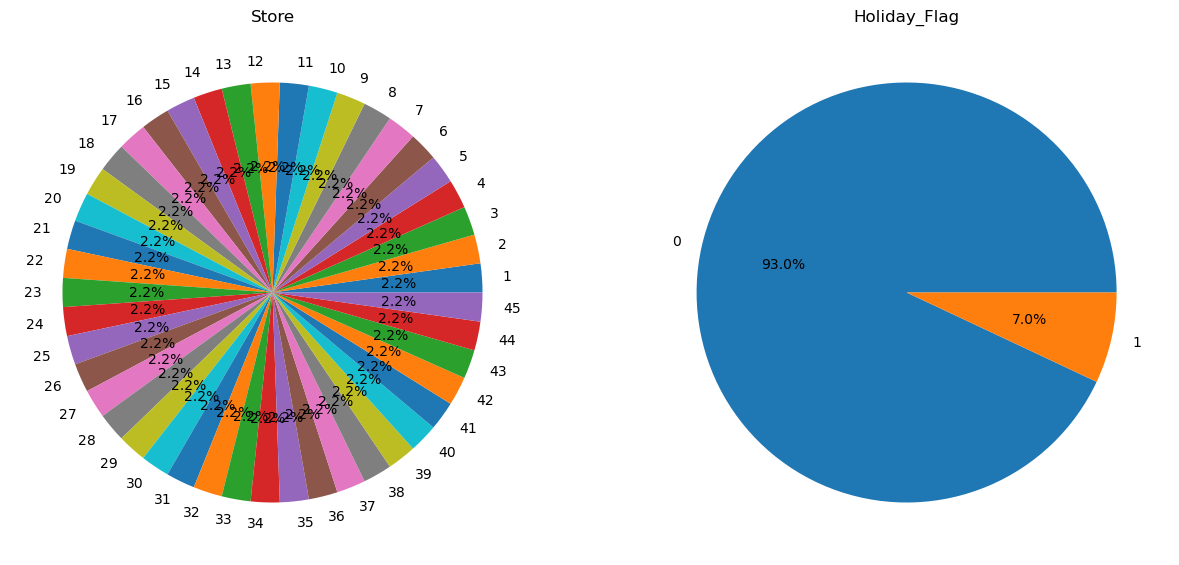

In [23]:
columns = ['Store', 'Holiday_Flag']
plt.figure(figsize=(15,15))
for col in columns:
  count_values = df[col].value_counts()
  print(count_values,end='\n\n')
  plt.subplot(2,2,columns.index(col)+1)
  plt.title(col)    
  plt.pie(count_values,labels=count_values.index,autopct='%1.1f%%')
  plt.axis('off')
plt.show()

In [24]:
# Convert the 'Date' column to datetime
df_clean['Date'] = pd.to_datetime(df_clean['Date'], format='%d-%m-%Y', errors='coerce')

# --- Temporal Features ---
df_clean['Year'] = df_clean['Date'].dt.year                         # Year (e.g., 2010, 2011, ...)
df_clean['Quarter'] = df_clean['Date'].dt.quarter                   # Quarter of the year (1–4)
df_clean['Month'] = df_clean['Date'].dt.month                       # Month (1–12)
df_clean['Week'] = df_clean['Date'].dt.isocalendar().week           # ISO Week number
df_clean['Day'] = df_clean['Date'].dt.day                           # Day of the month

In [25]:
# Total Sales
total_sales = df_clean['Weekly_Sales'].sum()
print(f"\nTotal Sales: {total_sales:,.2f}")


Total Sales: 6,632,270,392.99


In [26]:
# Sales by Year
sales_by_year = df_clean.groupby('Year')['Weekly_Sales'].sum()
print("\n--- Sales by Year ---")
print(sales_by_year)


--- Sales by Year ---
Year
2010    2.227566e+09
2011    2.404571e+09
2012    2.000133e+09
Name: Weekly_Sales, dtype: float64


In [27]:
# Sales by Store
sales_by_store = df_clean.groupby('Store')['Weekly_Sales'].sum().sort_values(ascending=False)
print("\n--- Top 5 Stores by Sales ---")
print(sales_by_store.head())


--- Top 5 Stores by Sales ---
Store
4     2.810352e+08
20    2.800237e+08
14    2.761276e+08
2     2.687221e+08
13    2.682025e+08
Name: Weekly_Sales, dtype: float64


#### Feature Engineering

In [28]:
# --- Economic & Contextual Features ---
df_clean['Employment'] = 100 - df_clean['Unemployment']             # Estimated employment rate
df_clean['Economic_Stress'] = df_clean['CPI'] * df_clean['Unemployment']  # Proxy for economic tension
df_clean['Fuel_Temp_Interaction'] = df_clean['Fuel_Price'] * df_clean['Temperature']  # Interaction term

# --- Holiday Context Features ---
df_clean['Is_PreHoliday'] = df_clean['Holiday_Flag'].shift(-1).fillna(0).astype(int)  # Week before a holiday
df_clean['Is_PostHoliday'] = df_clean['Holiday_Flag'].shift(1).fillna(0).astype(int)  # Week after a holiday

# --- Store-Level Aggregated Features ---
df_clean['Store_Avg_Sales'] = df_clean.groupby('Store')['Weekly_Sales'].transform('mean')  # Avg sales per store
df_clean['Store_Sales_Deviation'] = df_clean['Weekly_Sales'] - df_clean['Store_Avg_Sales']       # Deviation from store average

# Convert temporal features to categorica
df_clean['Year'] = df_clean['Year'].astype('category')
df_clean['Quarter'] = df_clean['Quarter'].astype('category')
df_clean['Month'] = df_clean['Month'].astype('category')
df_clean['Week'] = df_clean['Week'].astype('category')
df_clean['Day'] = df_clean['Day'].astype('category')

# Binary flags to categorical
df_clean['Is_PreHoliday'] = df_clean['Is_PreHoliday'].astype('category')
df_clean['Is_PostHoliday'] = df_clean['Is_PostHoliday'].astype('category')

# Preview the enriched dataset
print(df_clean.head(3))


  Store       Date  Weekly_Sales Holiday_Flag  Temperature  Fuel_Price  \
0     1 2010-02-05    1643690.90            0        42.31       2.572   
1     1 2010-02-12    1641957.44            1        38.51       2.548   
2     1 2010-02-19    1611968.17            0        39.93       2.514   

          CPI  Unemployment  Year Quarter Month Week Day  Employment  \
0  211.096358         8.106  2010       1     2    5   5      91.894   
1  211.242170         8.106  2010       1     2    6  12      91.894   
2  211.289143         8.106  2010       1     2    7  19      91.894   

   Economic_Stress  Fuel_Temp_Interaction Is_PreHoliday Is_PostHoliday  \
0      1711.147080              108.82132             1              0   
1      1712.329028               98.12348             0              0   
2      1712.709792              100.38402             0              1   

   Store_Avg_Sales  Store_Sales_Deviation  
0     1.555264e+06           88426.502448  
1     1.555264e+06           

### Preprocessing Analysis
---

No missing values were found in the dataset, and duplicate entries were not present. Several extreme values were identified through distributional plots and skewness metrics, particularly in `Weekly_Sales` and `Store_Sales_Deviation`. However, these outliers appear realistic given the business context (e.g., holiday spikes or large-format stores) and were retained.

Feature engineering introduced several meaningful variables, including:
- **Is_PreHoliday** and **Is_PostHoliday** flags,
- **Fuel_Temp_Interaction** to capture weather-related demand signals,
- **Economic_Stress Index** combining CPI and unemployment,
- **Store_Sales_Deviation** for tracking store-level performance relative to historical norms.

These engineered features were designed to enhance model interpretability and improve predictive accuracy.

---

### Exploratory Data Analysis (EDA)
---

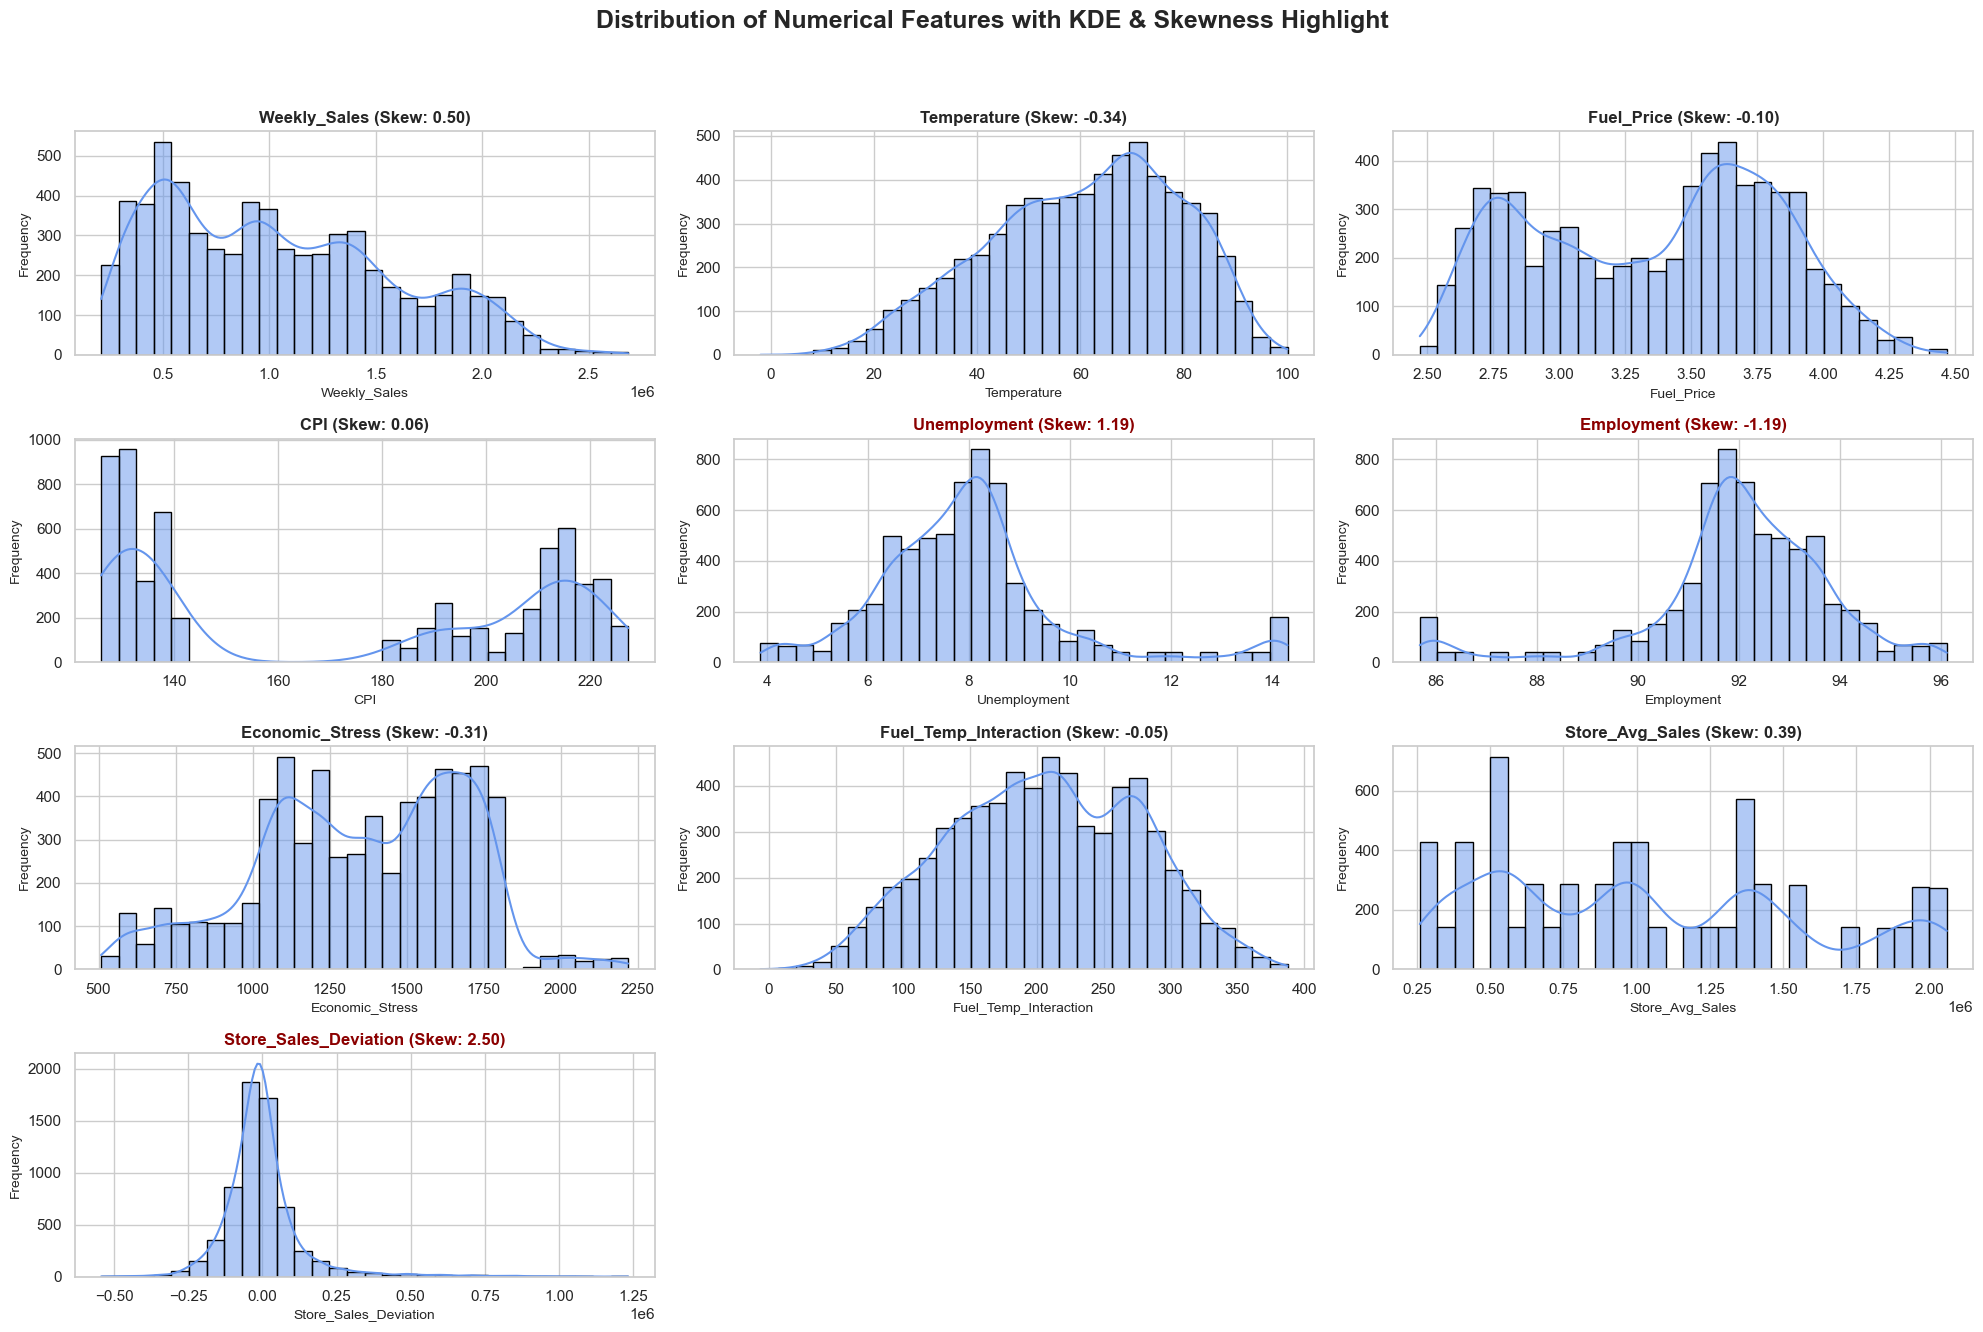

In [29]:
#  Feature Distributions

# Set seaborn style for clean visuals
sns.set(style="whitegrid")

# Select only numeric features
num_cols = df_clean.select_dtypes(include=['float64', 'int64']).columns

# Calculate skewness for each feature
skewness = df_clean[num_cols].apply(skew).sort_values(ascending=False)

# Set plot layout
n_cols = 3
n_rows = int(np.ceil(len(num_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 14))
axes = axes.flatten()

# Plot histograms with KDE overlay and skewness info
for i, col in enumerate(num_cols):
    sns.histplot(df_clean[col], bins=30, kde=True, color='cornflowerblue', edgecolor='black', ax=axes[i])

    skew_val = skewness[col]
    skew_label = f" (Skew: {skew_val:.2f})"

    # Highlight skewed features with a red title
    if abs(skew_val) > 1:
        axes[i].set_title(f"{col}{skew_label}", fontsize=12, fontweight='bold', color='darkred')
    else:
        axes[i].set_title(f"{col}{skew_label}", fontsize=12, fontweight='bold')

    axes[i].set_xlabel(col, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Global title
fig.suptitle('Distribution of Numerical Features with KDE & Skewness Highlight', 
             fontsize=18, fontweight='bold')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


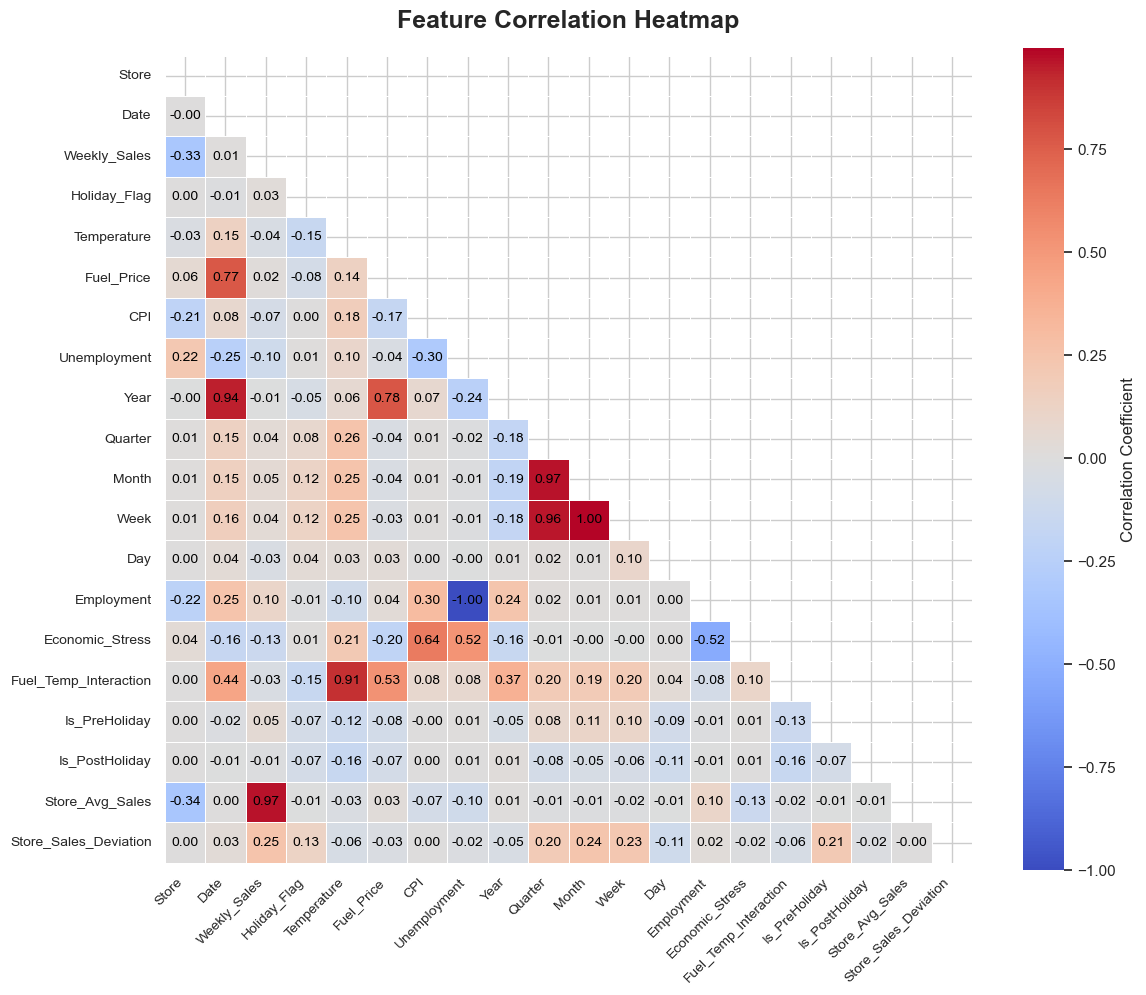

In [30]:
#  Correlation Heatmap

corr = df_clean.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with a mask for the upper triangle (optional for clarity)
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(
    corr, 
    mask=mask,                      # hides upper triangle
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar_kws={'shrink': 1.0, 'label': 'Correlation Coefficient'},
    square=True, 
    linewidths=0.5, 
    annot_kws={"size": 10, "color": "black"}
)

# Title and aesthetics
plt.title("Feature Correlation Heatmap", fontsize=18, fontweight="bold", pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)

plt.tight_layout()
plt.show()

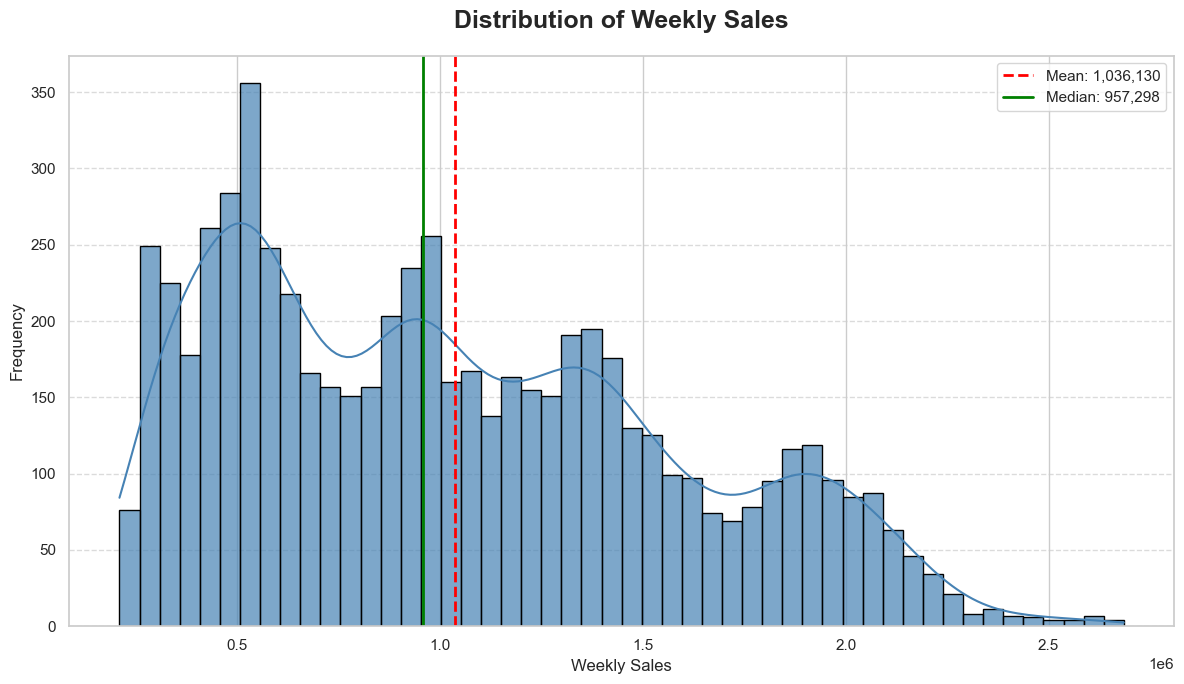

In [31]:
#  Weekly Sales Distribution

plt.figure(figsize=(12, 7))

# Plot histogram with KDE and rug
sns.histplot(
    df_clean['Weekly_Sales'], 
    bins=50, 
    kde=True, 
    color='steelblue', 
    edgecolor='black', 
    alpha=0.7
)

# Add vertical line for mean & median
mean_val = df_clean['Weekly_Sales'].mean()
median_val = df_clean['Weekly_Sales'].median()

plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f"Mean: {mean_val:,.0f}")
plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f"Median: {median_val:,.0f}")

# Titles and labels
plt.title("Distribution of Weekly Sales", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Weekly Sales", fontsize=12)
plt.ylabel("Frequency", fontsize=12)

# Grid and legend
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(fontsize=11, frameon=True)

# Tight layout
plt.tight_layout()
plt.show()

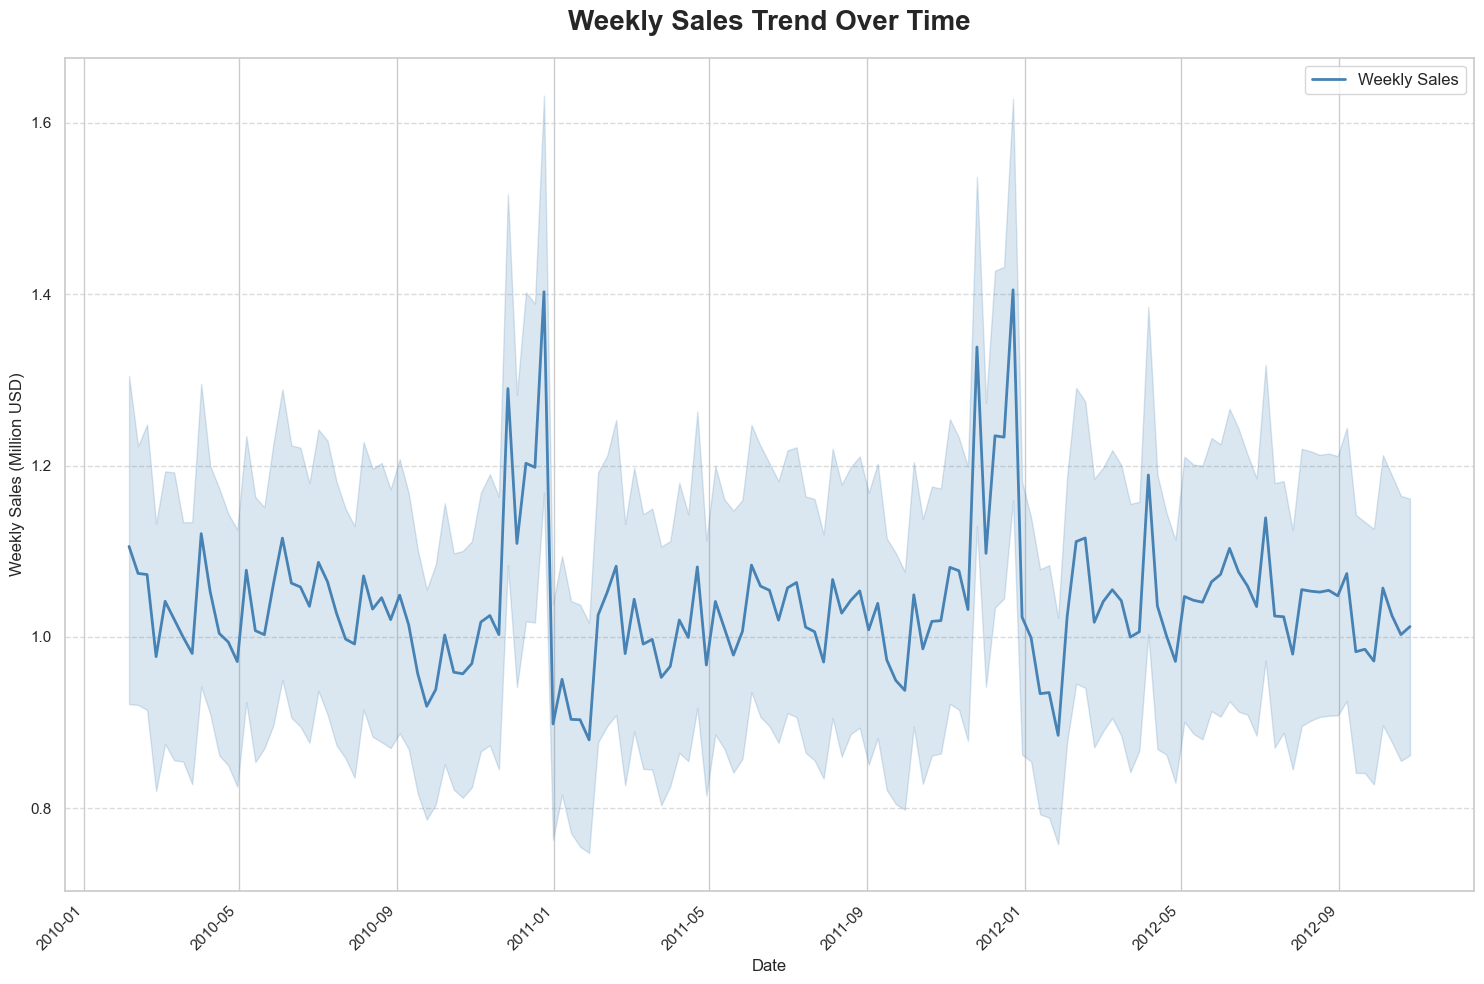

In [32]:
#  Weekly Sales Over Time

plt.figure(figsize=(15, 10))

# Lineplot with smoothing
sns.lineplot(
    x="Date", 
    y=df_clean['Weekly_Sales'] / 1e6, 
    data=df_clean, 
    color="steelblue", 
    linewidth=2, 
    label="Weekly Sales"
)

# Titles and labels
plt.title("Weekly Sales Trend Over Time", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Weekly Sales (Million USD)", fontsize=12)

# Format x-axis ticks (rotate & reduce clutter)
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add legend
plt.legend(fontsize=12, frameon=True)

plt.tight_layout()
plt.show()

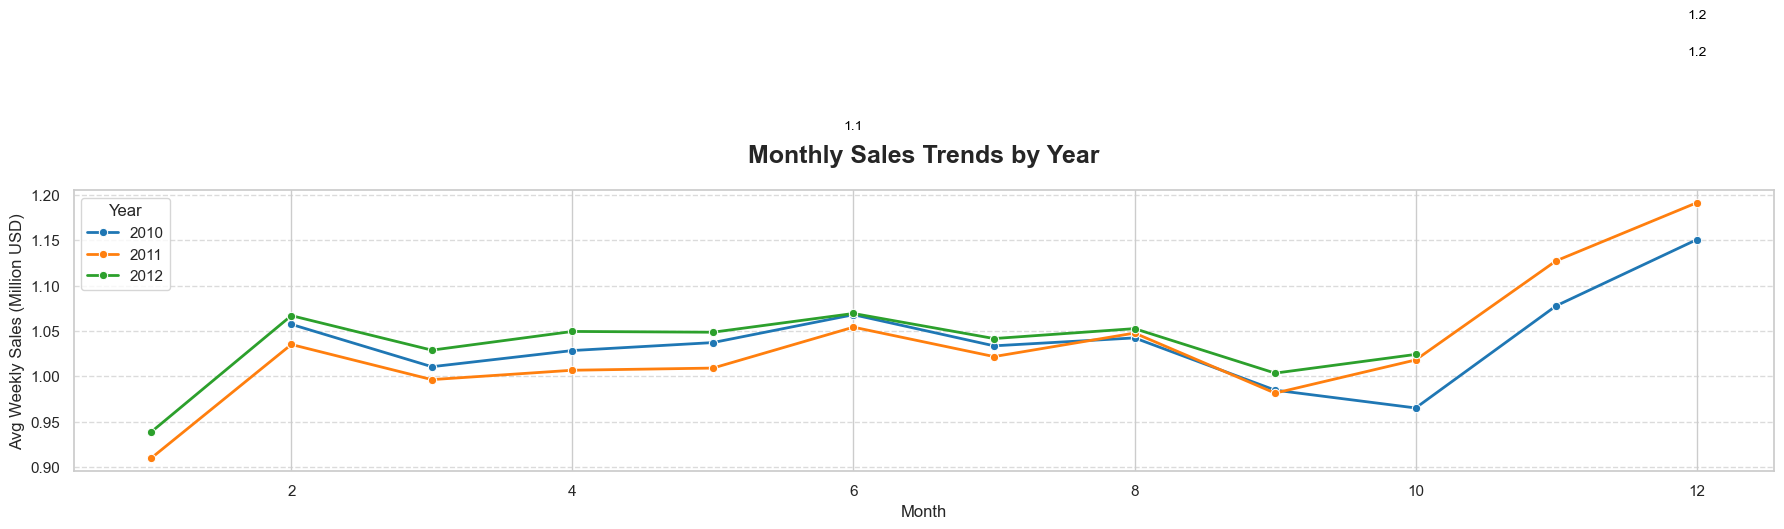

In [33]:
#  Monthly Sales Trends (2010-2012)

# Pivot table (ensuring correct month order)
pivot_table = df_clean.pivot_table(
    index='Month', 
    columns='Year', 
    values='Weekly_Sales', 
    aggfunc='mean'
).sort_index()

plt.figure(figsize=(18, 7))

# Loop through years dynamically
palette = sns.color_palette("tab10", n_colors=len(pivot_table.columns))
for i, year in enumerate(pivot_table.columns):
    sns.lineplot(
        x=pivot_table.index, 
        y=pivot_table[year] / 1e6, 
        label=str(year),
        linewidth=2,
        marker="o",
        color=palette[i]
    )

# Highlight the maximum sales point per year
for year in pivot_table.columns:
    max_month = pivot_table[year].idxmax()
    max_value = pivot_table[year].max() / 1e6
    plt.text(max_month, max_value + 0.2, f"{max_value:.1f}", 
             ha="center", va="bottom", fontsize=10, color="black")

# Labels and titles
plt.ylabel("Avg Weekly Sales (Million USD)", fontsize=12)
plt.xlabel("Month", fontsize=12)
plt.title("Monthly Sales Trends by Year", fontsize=18, fontweight="bold", pad=20)

# Improve x-axis (month names instead of numbers if available)
if df_clean["Month"].dtype == "int64":
    plt.xticks(pivot_table.index, 
               [pd.to_datetime(str(m), format="%m").strftime("%b") for m in pivot_table.index])

plt.legend(title="Year", fontsize=11, title_fontsize=12, frameon=True)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


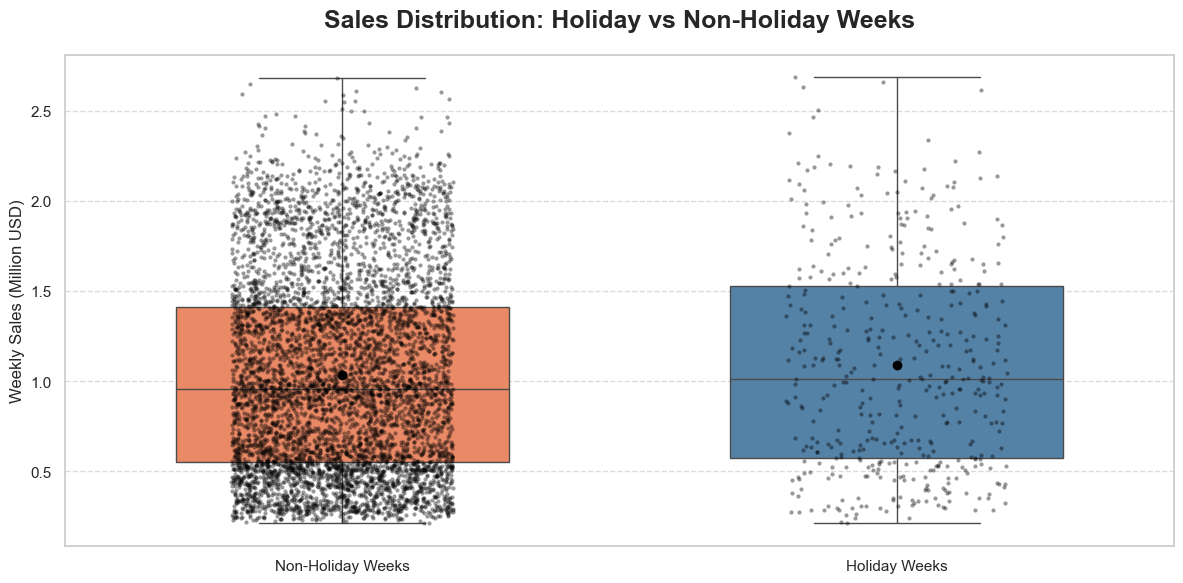

In [34]:
#  Holiday vs Non-Holiday Weekly Sales

# Prepare data
df_box = df_clean.copy()
df_box['Sales_Million'] = df_box['Weekly_Sales'] / 1e6
df_box['Holiday_Label'] = df_box['Holiday_Flag'].map({0: 'Non-Holiday Weeks', 1: 'Holiday Weeks'})

plt.figure(figsize=(12, 6))

# Boxplot with swarm/strip for distribution
sns.boxplot(
    x="Holiday_Label", 
    y="Sales_Million", 
    data=df_box, 
    palette=["#FF7F50", "#4682B4"], 
    width=0.6, 
    showmeans=True,
    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"}
)
sns.stripplot(
    x="Holiday_Label", 
    y="Sales_Million", 
    data=df_box, 
    color="black", 
    size=3, 
    jitter=0.2, 
    alpha=0.4
)

# Titles and labels
plt.title("Sales Distribution: Holiday vs Non-Holiday Weeks", fontsize=18, fontweight="bold", pad=20)
plt.ylabel("Weekly Sales (Million USD)", fontsize=12)
plt.xlabel("")

# Grid for readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### Model Building & Evaluation
---

In [35]:
# Data Preparation

# Drop columns that could leak target info or are no longer needed
df_clean.drop([
    'Date',                   # Already extracted temporal features
    'Unemployment',           # Used to create 'Employment'
    'Store_Sales_Deviation',  # Derived from target → target leakage
    'Is_PostHoliday',         # Leaks future info
    'Store_Avg_Sales'         # Derived from target → leakage
], axis=1, inplace=True)

# Separate features and target
X = df_clean.drop('Weekly_Sales', axis=1).copy()
y = df_clean['Weekly_Sales'].copy()

# Set Store as categorical
X['Store'] = X['Store'].astype('category')

# Train-test split (before encoding/scaling)
X_train_full, X_test_full, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Preprocessing for Ridge, Tree, Forest (One-Hot + Scaling)

# One-hot encode 'Store' for models that require numeric input
X_train_enc = pd.get_dummies(X_train_full, columns=['Store'], drop_first=True)
X_test_enc = pd.get_dummies(X_test_full, columns=['Store'], drop_first=True)

# Align columns
X_train_enc, X_test_enc = X_train_enc.align(X_test_enc, join='left', axis=1, fill_value=0)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_enc)
X_test_scaled = scaler.transform(X_test_enc)


# Preprocessing for XGBoost and LGBM (No one-hot, Store kept categorical)

X_train_boost = X_train_full.copy()
X_test_boost = X_test_full.copy()


In [36]:
# Model Initialization

ridge = Ridge()
tree = DecisionTreeRegressor(random_state=42)
forest = RandomForestRegressor(random_state=42)
xgb = XGBRegressor(enable_categorical=True, random_state=42, verbosity=0)
lgbm = LGBMRegressor(random_state=42, verbose=-1)


# Parameter Grids


param_grid_ridge = {'alpha': loguniform(1e-2, 10)}

param_grid_tree = {
    'max_depth': randint(3, 20),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

param_grid_forest = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

param_grid_xgb = {
    'n_estimators': randint(100, 200),
    'learning_rate': loguniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

param_grid_lgbm = {
    'n_estimators': randint(100, 300),
    'learning_rate': loguniform(0.01, 0.1),
    'num_leaves': randint(31, 128),
    'min_child_samples': randint(5, 30),
    'reg_alpha': loguniform(1e-3, 0.5),
    'reg_lambda': loguniform(1e-3, 0.5)
}


# Randomized Hyperparameter Search


searches = {
    'Ridge': RandomizedSearchCV(ridge, param_grid_ridge, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'Decision Tree': RandomizedSearchCV(tree, param_grid_tree, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'Random Forest': RandomizedSearchCV(forest, param_grid_forest, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'XGBoost': RandomizedSearchCV(xgb, param_grid_xgb, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise'),
    'LGBM': RandomizedSearchCV(lgbm, param_grid_lgbm, cv=5, n_iter=25, scoring='neg_root_mean_squared_error', random_state=42, n_jobs=-1, verbose=0, error_score='raise')
}

# -------------------------
# Execute Search and Display Results
# -------------------------

results = {}
for name, search in searches.items():
    print(f"Tuning {name}...")
    if name in ['Ridge', 'Decision Tree', 'Random Forest']:
        search.fit(X_train_scaled, y_train)
        y_pred = search.best_estimator_.predict(X_test_scaled)
    else:
        search.fit(X_train_boost, y_train)
        y_pred = search.best_estimator_.predict(X_test_boost)

    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Best Params for {name}: {search.best_params_}")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²:   {r2:.4f}")
    print("-" * 50)

    results[name] = {
        'estimator': search.best_estimator_,
        'rmse': rmse,
        'r2': r2,
        'predictions': y_pred
    }


Tuning Ridge...
Best Params for Ridge: {'alpha': np.float64(0.011527987128232402)}
  RMSE: 136819.27
  R²:   0.9411
--------------------------------------------------
Tuning Decision Tree...
Best Params for Decision Tree: {'max_depth': 19, 'min_samples_leaf': 4, 'min_samples_split': 3}
  RMSE: 261820.84
  R²:   0.7841
--------------------------------------------------
Tuning Random Forest...
Best Params for Random Forest: {'max_depth': 29, 'min_samples_leaf': 9, 'min_samples_split': 6, 'n_estimators': 114}
  RMSE: 126683.39
  R²:   0.9495
--------------------------------------------------
Tuning XGBoost...
Best Params for XGBoost: {'colsample_bytree': np.float64(0.9908753883293675), 'learning_rate': np.float64(0.10196967939171485), 'max_depth': 4, 'n_estimators': 173, 'subsample': np.float64(0.9684482051282945)}
  RMSE: 59372.43
  R²:   0.9889
--------------------------------------------------
Tuning LGBM...
Best Params for LGBM: {'learning_rate': np.float64(0.07643288611715515), 'min_

In [37]:
# Evaluation Functions
# -------------------------

def evaluate_regressors_metrics(regressors, regressor_names, 
                                 X_train_scaled, y_train, X_test_scaled, y_test,
                                 X_train_boost, X_test_boost):
    metrics = []
    all_preds = []
    fitted_models = []

    for i, regressor in enumerate(regressors):
        name = regressor_names[i]
        if name in ['Ridge Regression', 'Decision Tree Regression', 'Random Forest']:
            X_test_in = X_test_scaled
        else:
            X_test_in = X_test_boost

        y_pred = regressor.predict(X_test_in)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        metrics.append([mse, rmse, mae, r2])
        all_preds.append(y_pred)
        fitted_models.append(regressor)

    metrics_df = pd.DataFrame(metrics, columns=['MSE', 'RMSE', 'MAE', 'R2'])
    metrics_df['Regressor'] = regressor_names
    metrics_df = metrics_df.sort_values('RMSE').reset_index(drop=True)

    all_preds = [all_preds[i] for i in metrics_df.index]
    fitted_models = [fitted_models[i] for i in metrics_df.index]
    return metrics_df, all_preds, fitted_models

In [38]:
# Final Model Evaluation
# -------------------------

regressors = [searches[name].best_estimator_ for name in searches]
regressor_names = [
    "Ridge Regression", "Decision Tree Regression", "Random Forest",
    "XGBoost Regression", "LightGBM Regression"
]

metrics_df, all_preds, fitted_models = evaluate_regressors_metrics(
    regressors, regressor_names,
    X_train_scaled, y_train, X_test_scaled, y_test,
    X_train_boost, X_test_boost
)

best_model_index = metrics_df['RMSE'].idxmin()
best_model_name = metrics_df.loc[best_model_index, 'Regressor']
best_rmse = metrics_df.loc[best_model_index, 'RMSE']
best_r2 = metrics_df.loc[best_model_index, 'R2']
best_model_instance = fitted_models[best_model_index]
y_pred = all_preds[best_model_index]
median_sale = y_test.median()
percent_deviation = round((best_rmse * 100 / median_sale), 2)


# Print summary
print("Regressor Results")
print(metrics_df)
print()
print()

print(f"Best Model: {best_model_name}")
print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best R²:   {best_r2:.4f}")
print(f"Average % Error: {percent_deviation}%")
print()

Regressor Results
            MSE           RMSE            MAE        R2  \
0  3.525085e+09   59372.426177   38845.590773  0.988900   
1  3.758377e+09   61305.603124   37255.781742  0.988165   
2  1.604868e+10  126683.387560   73597.836266  0.949463   
3  1.871951e+10  136819.270546   88736.626281  0.941053   
4  6.855015e+10  261820.836975  187897.226013  0.784138   

                  Regressor  
0        XGBoost Regression  
1       LightGBM Regression  
2             Random Forest  
3          Ridge Regression  
4  Decision Tree Regression  


Best Model: XGBoost Regression
Best RMSE: 59372.43
Best R²:   0.9889
Average % Error: 6.07%



In [39]:
# Verify Results with Cross Validation

# Store results
cv_scores = {'XGBoost': [], 'LGBM': []}
cv_r2s = {'XGBoost': [], 'LGBM': []}

kf = KFold(n_splits=5, shuffle=True, random_state=42)

X = df_clean.drop(['Weekly_Sales'], axis=1).copy()
y = df_clean['Weekly_Sales'].copy()

# Cast Store to categorical explicitly (ensures compatibility)
X['Store'] = X['Store'].astype('category')

# Loop through each fold
for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
    print(f"\nFold {fold+1}:")

    # Split the fold
    X_train_fold = X.iloc[train_idx].copy()
    X_val_fold = X.iloc[val_idx].copy()
    y_train_fold = y.iloc[train_idx]
    y_val_fold = y.iloc[val_idx]

    # Ensure categorical type is preserved
    X_train_fold['Store'] = X_train_fold['Store'].astype('category')
    X_val_fold['Store'] = X_val_fold['Store'].astype('category')

    # ----------------------
    # XGBoost
    # ----------------------
    
    xgb_fold = XGBRegressor(
        **results['XGBoost']['estimator'].get_params()
)
    
    xgb_fold.fit(X_train_fold, y_train_fold)
    y_pred_xgb = xgb_fold.predict(X_val_fold)

    rmse_xgb = np.sqrt(mean_squared_error(y_val_fold, y_pred_xgb))
    r2_xgb = r2_score(y_val_fold, y_pred_xgb)

    cv_scores['XGBoost'].append(rmse_xgb)
    cv_r2s['XGBoost'].append(r2_xgb)

    # ----------------------
    # LightGBM
    # ----------------------
    lgbm_fold = LGBMRegressor(
        **results['LGBM']['estimator'].get_params()
    )

    lgbm_fold.fit(X_train_fold, y_train_fold)
    y_pred_lgbm = lgbm_fold.predict(X_val_fold)

    rmse_lgbm = np.sqrt(mean_squared_error(y_val_fold, y_pred_lgbm))
    r2_lgbm = r2_score(y_val_fold, y_pred_lgbm)

    cv_scores['LGBM'].append(rmse_lgbm)
    cv_r2s['LGBM'].append(r2_lgbm)

    print(f"  XGBoost  → RMSE: {rmse_xgb:.2f}, R²: {r2_xgb:.4f}")
    print(f"  LightGBM → RMSE: {rmse_lgbm:.2f}, R²: {r2_lgbm:.4f}")
    print()
    
print()
print("\n--- Cross-Validation Summary ---")

for model in ['XGBoost', 'LGBM']:
    rmse_mean = np.mean(cv_scores[model])
    rmse_std = np.std(cv_scores[model])
    r2_mean = np.mean(cv_r2s[model])
    r2_std = np.std(cv_r2s[model])

    print(f"{model} RMSE: {rmse_mean:.2f} ± {rmse_std:.2f}")
    print(f"{model} R²:   {r2_mean:.4f} ± {r2_std:.4f}")
    print("-" * 40)


Fold 1:
  XGBoost  → RMSE: 59578.49, R²: 0.9888
  LightGBM → RMSE: 61305.60, R²: 0.9882


Fold 2:
  XGBoost  → RMSE: 55414.31, R²: 0.9891
  LightGBM → RMSE: 52361.95, R²: 0.9903


Fold 3:
  XGBoost  → RMSE: 55870.70, R²: 0.9894
  LightGBM → RMSE: 53010.76, R²: 0.9904


Fold 4:
  XGBoost  → RMSE: 53703.38, R²: 0.9900
  LightGBM → RMSE: 51656.35, R²: 0.9908


Fold 5:
  XGBoost  → RMSE: 56044.14, R²: 0.9896
  LightGBM → RMSE: 54501.94, R²: 0.9902



--- Cross-Validation Summary ---
XGBoost RMSE: 56122.20 ± 1916.62
XGBoost R²:   0.9894 ± 0.0004
----------------------------------------
LGBM RMSE: 54567.32 ± 3497.69
LGBM R²:   0.9900 ± 0.0009
----------------------------------------


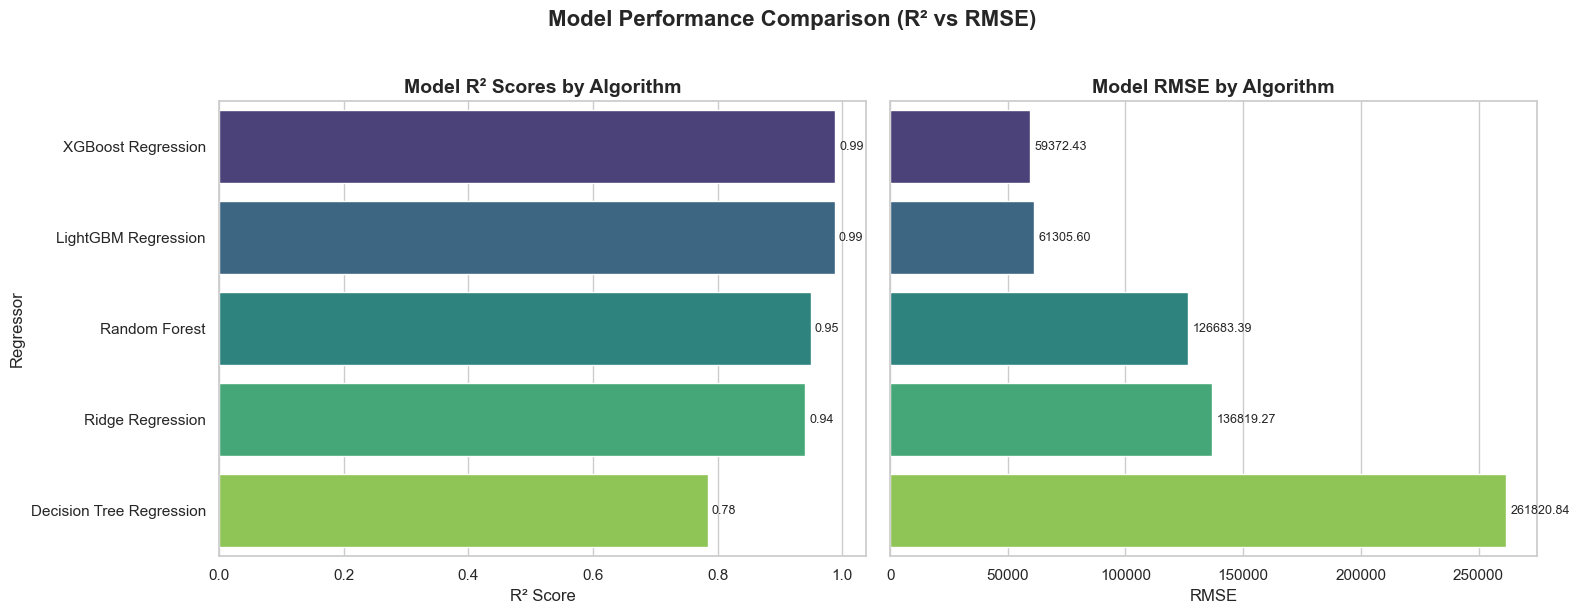

In [42]:
# R² and RMSE Comparison
# -------------------------

# Sort models by R² for consistent ordering
metrics_sorted = metrics_df.sort_values("R2", ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# --- R² Plot ---
sns.barplot(
    data=metrics_sorted, 
    x="R2", 
    y="Regressor", 
    ax=axes[0], 
    palette="viridis"
)
axes[0].set_title("Model R² Scores by Algorithm", fontsize=14, fontweight="bold")
axes[0].set_xlabel("R² Score")
axes[0].set_ylabel("Regressor")

# Add value labels
for container in axes[0].containers:
    axes[0].bar_label(container, fmt="%.2f", fontsize=9, padding=3)

# --- RMSE Plot ---
sns.barplot(
    data=metrics_sorted, 
    x="RMSE", 
    y="Regressor", 
    ax=axes[1], 
    palette="viridis"
)
axes[1].set_title("Model RMSE by Algorithm", fontsize=14, fontweight="bold")
axes[1].set_xlabel("RMSE")
axes[1].set_ylabel("")

# Add value labels
for container in axes[1].containers:
    axes[1].bar_label(container, fmt="%.2f", fontsize=9, padding=3)

# Adjust layout
plt.suptitle("Model Performance Comparison (R² vs RMSE)", fontsize=16, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

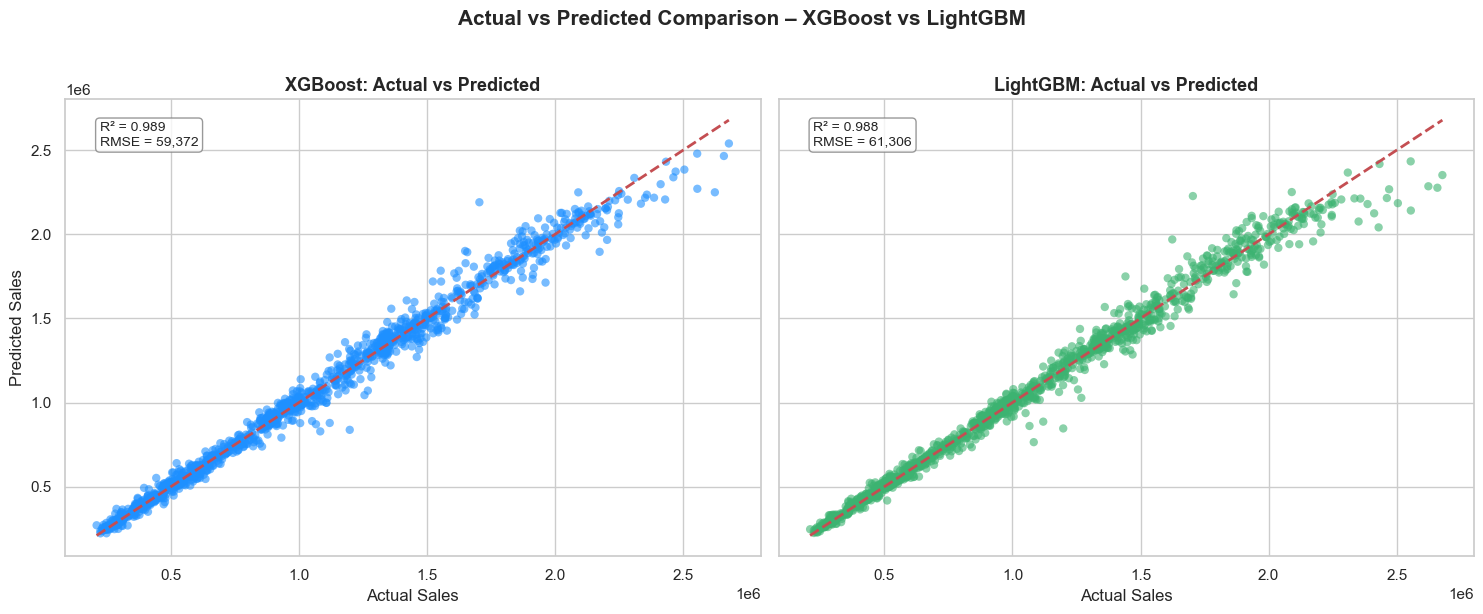

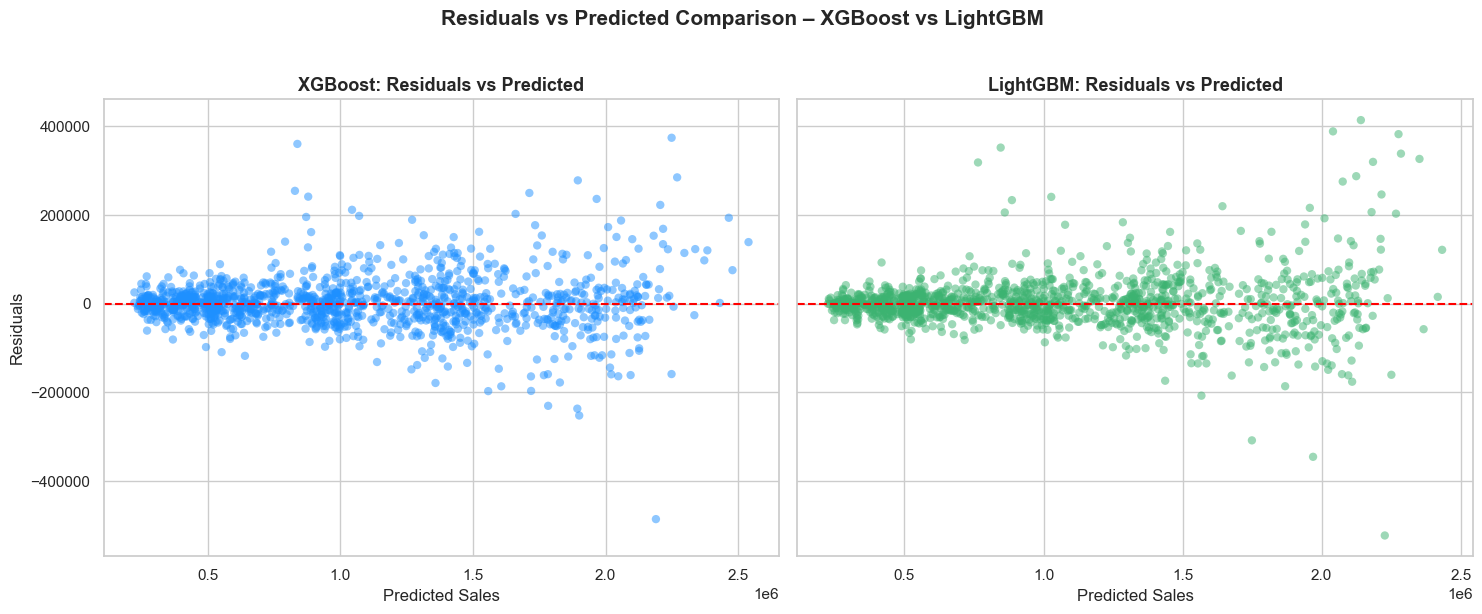

In [44]:
# Actual vs Predicted Comparison (XGBoost vs LGBM)
# -------------------------

# Extract predictions, residuals, and metrics
pred_xgb = results['XGBoost']['predictions']
pred_lgbm = results['LGBM']['predictions']
residuals_xgb = y_test - pred_xgb
residuals_lgbm = y_test - pred_lgbm
r2_xgb, rmse_xgb = results['XGBoost']['r2'], results['XGBoost']['rmse']
r2_lgbm, rmse_lgbm = results['LGBM']['r2'], results['LGBM']['rmse']

# ------------------------------
# Actual vs Predicted Comparison
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)

models = {
    "XGBoost": (pred_xgb, r2_xgb, rmse_xgb, "dodgerblue"),
    "LightGBM": (pred_lgbm, r2_lgbm, rmse_lgbm, "mediumseagreen")
}

for ax, (name, (preds, r2, rmse, color)) in zip(axes, models.items()):
    sns.scatterplot(x=y_test, y=preds, alpha=0.6, color=color, edgecolor="none", ax=ax)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    
    ax.set_title(f"{name}: Actual vs Predicted", fontsize=13, fontweight="bold")
    ax.set_xlabel("Actual Sales")
    ax.set_ylabel("Predicted Sales")
    
    # Annotate metrics
    ax.text(
        0.05, 0.95,
        f"R² = {r2:.3f}\nRMSE = {rmse:,.0f}",
        transform=ax.transAxes,
        fontsize=10, ha="left", va="top",
        bbox=dict(facecolor="white", edgecolor="gray", alpha=0.8, boxstyle="round,pad=0.3")
    )

fig.suptitle("Actual vs Predicted Comparison – XGBoost vs LightGBM", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()

# ------------------------------
# Residuals vs Predicted Comparison
# ------------------------------
fig, axes = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

for ax, (name, (preds, r2, rmse, color)) in zip(axes, models.items()):
    sns.scatterplot(x=preds, y=y_test - preds, alpha=0.5, color=color, edgecolor="none", ax=ax)
    ax.axhline(0, color="red", linestyle="--", lw=1.5)
    
    ax.set_title(f"{name}: Residuals vs Predicted", fontsize=13, fontweight="bold")
    ax.set_xlabel("Predicted Sales")
    ax.set_ylabel("Residuals")

fig.suptitle("Residuals vs Predicted Comparison – XGBoost vs LightGBM", fontsize=15, fontweight="bold", y=1.02)
plt.tight_layout()
plt.show()


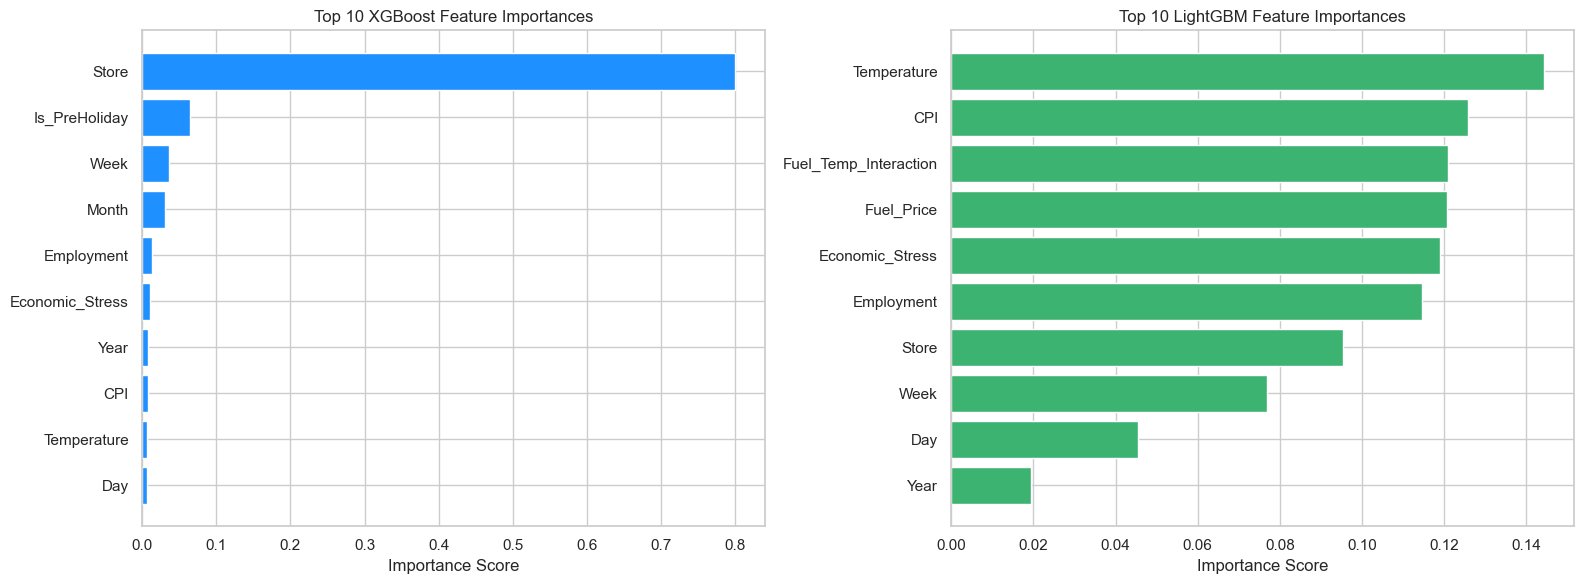

In [45]:
# Feature Importance Visualization (XGBoost & LightGBM)
# -------------------------

# Extract feature importances
def get_top_features(model, feature_names, top_n=10, normalize=False):
    importances = model.feature_importances_
    if normalize:
        importances = importances / np.sum(importances)
    indices = np.argsort(importances)[-top_n:]
    return [feature_names[i] for i in indices], importances[indices]

# Get top 10 features for XGBoost and LightGBM
xgb_features, xgb_importances = get_top_features(
    model=results['XGBoost']['estimator'],
    feature_names=X_train_boost.columns,
    top_n=10,
    normalize=False
)

lgbm_features, lgbm_importances = get_top_features(
    model=results['LGBM']['estimator'],
    feature_names=X_train_boost.columns,
    top_n=10,
    normalize=True
)

# Create side-by-side bar plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=False)

# XGBoost Plot
axes[0].barh(range(len(xgb_features)), xgb_importances, color='dodgerblue')
axes[0].set_yticks(range(len(xgb_features)))
axes[0].set_yticklabels(xgb_features)
axes[0].set_title("Top 10 XGBoost Feature Importances")
axes[0].set_xlabel("Importance Score")

# LightGBM Plot
axes[1].barh(range(len(lgbm_features)), lgbm_importances, color='mediumseagreen')
axes[1].set_yticks(range(len(lgbm_features)))
axes[1].set_yticklabels(lgbm_features)
axes[1].set_title("Top 10 LightGBM Feature Importances")
axes[1].set_xlabel("Importance Score")

plt.tight_layout()
plt.show()